# Comparing likelihood models: there is a right way, and many wrong ways!

This time, we treat the overall normalization as a free parameter, rather than explicitly marginalizing over it.

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## make the model

In [3]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def y(self, x, m, b):
        return m * x + b

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

In [4]:
model = LinearModel()

In [5]:
rng = np.random.default_rng(18)

In [6]:
true_params = [0.6, 2]

In [7]:
settings = [
    {
        "domain": [0, 1],
        "N": 20,
        "noise": 0.2,
        "systematic_err": 0.2,
    },
    {
        "domain": [0, 1],
        "N": 20,
        "noise": 0.2,
        "systematic_err": 0.2,
    },
    {
        "domain": [0, 1],
        "N": 20,
        "noise": 0.2,
        "systematic_err": 0.2,
    },
    {
        "domain": [0, 1],
        "N": 20,
        "noise": 0.2,
        "systematic_err": 0.2,
    },
    {
        "domain": [0, 1],
        "N": 20,
        "noise": 0.2,
        "systematic_err": 0.2,
    },
    {
        "domain": [0, 1],
        "N": 20,
        "noise": 0.2,
        "systematic_err": 0.2,
    },
]

In [8]:
def generate_observations(settings, true_model, rng, true_params, scale_err=True):
    obs = []
    for setting in settings:
        x0, x1 = setting["domain"]
        synthetic_obs = rxmc.observation.Observation(
            x=rng.random(setting["N"]) * (x1 - x0) + x0,
            y=np.zeros(setting["N"]),
            y_stat_err=np.ones(setting["N"]) * setting["noise"],
            y_sys_err_normalization=setting["systematic_err"],
        )
        renormalization = rng.normal(1, setting["systematic_err"])
        y_true = true_model(synthetic_obs, *true_params)
        if scale_err:
            synthetic_obs.y = rng.normal(y_true, setting["noise"]) * renormalization
        else:
            synthetic_obs.y = rng.normal(y_true * renormalization, setting["noise"])

        synthetic_obs.renormalization = renormalization

        obs.append(synthetic_obs)
    return obs

In [9]:
observations = generate_observations(settings, model, rng, true_params, scale_err=True)

In [10]:
N_fine = 100
domain_fine = (0, 1)
truth = rxmc.observation.Observation(
    x=np.linspace(*domain_fine, N_fine), y=np.zeros(N_fine)
)
truth.y = model(truth, *true_params)

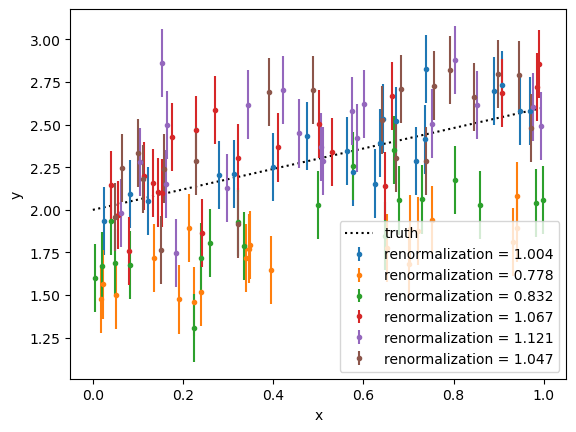

In [11]:
plt.plot(truth.x, truth.y, "k:", label="truth")
for synthetic_observation in observations:
    plt.errorbar(
        synthetic_observation.x,
        synthetic_observation.y,
        np.sqrt(np.diag(synthetic_observation.statistical_covariance)),
        linestyle="none",
        marker=".",
        label=f"renormalization = {synthetic_observation.renormalization:1.3f}",
    )
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## prior

In [12]:
prior_mean = np.array([1, 3])
prior_cov = np.array([[1, 0], [0, 1]])
prior_distribution = stats.multivariate_normal(prior_mean, prior_cov)

In [13]:
unknown_log_norm_priors = [
    stats.multivariate_normal(
        mean=[0], cov=[[np.log(1 + (setting["systematic_err"]) ** 2)]]
    )
    for setting in settings
]

## set up likelihood models and constraints

In [14]:
likelihood_koh = rxmc.likelihood_model.UnknownNormalizationModel()
likelihood_data_norm = rxmc.likelihood_model.UnknownDataNormalizationModel()

In [15]:
evidence_models = {
    "koh": rxmc.evidence.Evidence(
        parametric_constraints=[
            rxmc.constraint.Constraint(
                [obs],
                model,
                rxmc.likelihood_model.UnknownNormalizationModel(),
            )
            for obs in observations
        ]
    ),
    "data normalization": rxmc.evidence.Evidence(
        parametric_constraints=[
            rxmc.constraint.Constraint(
                [obs],
                model,
                rxmc.likelihood_model.UnknownDataNormalizationModel(),
            )
            for obs in observations
        ]
    ),
}

In [16]:
print("hyperparameters for each model:")
hyperparams = {}
for key, evidence_model in evidence_models.items():
    hyperparams[key] = []
    for constraint in evidence_model.parametric_constraints:
        for p in constraint.likelihood.params:
            hyperparams[key].append(p)
    print(f"{key}: {[p.name for p in hyperparams[key]]}")

hyperparameters for each model:
koh: ['log normalization', 'log normalization', 'log normalization', 'log normalization', 'log normalization', 'log normalization']
data normalization: ['log normalization', 'log normalization', 'log normalization', 'log normalization', 'log normalization', 'log normalization']


In [17]:
walkers = dict(
    [
        (
            key,
            rxmc.walker.Walker(
                rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
                    params=model.params,
                    starting_location=prior_distribution.mean,
                    prior=prior_distribution,
                    initial_proposal_cov=prior_distribution.cov,
                ),
                evidence=evidence,
                likelihood_samplers=[
                    rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
                        params=[p],
                        starting_location=np.array([0.0]),
                        prior=prior,
                        initial_proposal_cov=[[prior.cov]],
                    )
                    for p, prior in zip(hyperparams[key], unknown_log_norm_priors)
                ],
                rng=rng,
            ),
        )
        for key, evidence in evidence_models.items()
    ]
)

In [18]:
%%time
for key, walker in walkers.items():
    print(f"\nRunning {key}")
    walker.walk(n_steps=10000, burnin=5000, batch_size=1000)


Running koh
Burn-in batch 1/5 completed, 1000 steps.
Burn-in batch 2/5 completed, 1000 steps.
Burn-in batch 3/5 completed, 1000 steps.
Burn-in batch 4/5 completed, 1000 steps.
Burn-in batch 5/5 completed, 1000 steps.
Batch: 1/10 completed, 1000 steps. 
  Model parameter acceptance fraction: 0.349
  Likelihood parameter acceptance fractions: [0.475, 0.435, 0.496, 0.45, 0.41, 0.42]
Batch: 2/10 completed, 1000 steps. 
  Model parameter acceptance fraction: 0.350
  Likelihood parameter acceptance fractions: [0.475, 0.464, 0.447, 0.482, 0.46, 0.453]
Batch: 3/10 completed, 1000 steps. 
  Model parameter acceptance fraction: 0.395
  Likelihood parameter acceptance fractions: [0.458, 0.428, 0.456, 0.44, 0.449, 0.433]
Batch: 4/10 completed, 1000 steps. 
  Model parameter acceptance fraction: 0.365
  Likelihood parameter acceptance fractions: [0.426, 0.431, 0.435, 0.429, 0.474, 0.458]
Batch: 5/10 completed, 1000 steps. 
  Model parameter acceptance fraction: 0.412
  Likelihood parameter accepta

In [19]:
walkers.keys()

dict_keys(['koh', 'data normalization'])

In [20]:
colors = dict(zip(walkers.keys(), ["tab:blue", "tab:orange"]))
colors

{'koh': 'tab:blue', 'data normalization': 'tab:orange'}

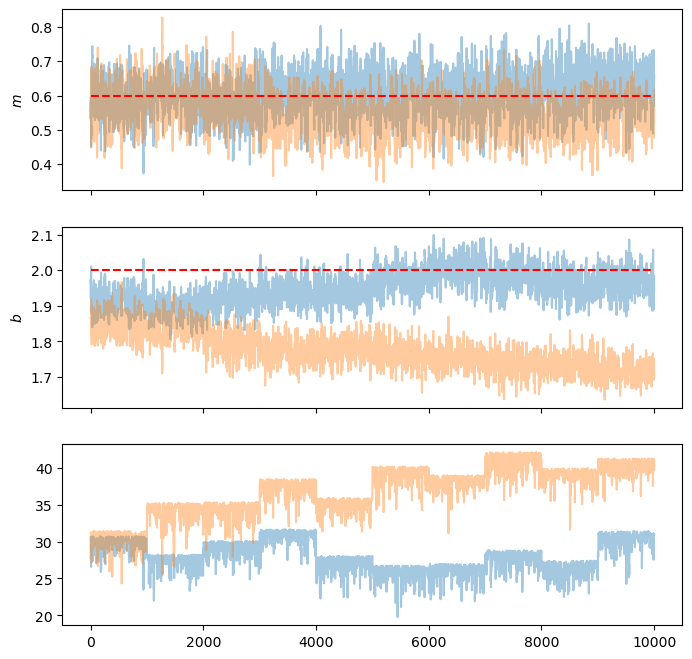

In [21]:
fig, axes = plt.subplots(
    walkers["koh"].model_sampler.chain.shape[1] + 1,
    1,
    figsize=(8, 8),
    sharex=True,
)
for i in range(walker.model_sampler.chain.shape[1]):
    # plot walkers
    for key, walker in walkers.items():
        axes[i].plot(walker.model_sampler.chain[:, i], alpha=0.4, color=colors[key])

    axes[i].set_ylabel(f"${model.params[i].latex_name}$")
    true_value = true_params[i]
    axes[i].hlines(true_value, 0, len(walker.model_sampler.chain), "r", linestyle="--")

# plot likelihoods
for key, walker in walkers.items():
    axes[-1].plot(walker.model_sampler.logp_chain, alpha=0.4, color=colors[key])

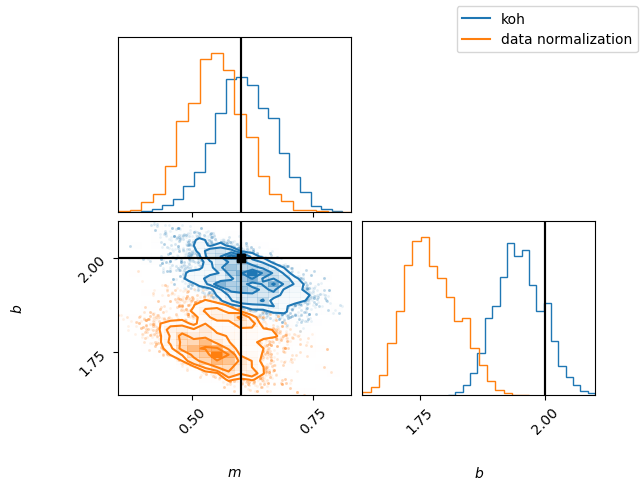

In [22]:
fig = plt.figure()
for key, walker in walkers.items():
    corner.corner(
        walker.model_sampler.chain,
        fig=fig,
        color=colors[key],
        labels=[f"${p.latex_name}$" for p in model.params],
        truths=true_params,
        labelpad=0.1,
        max_n_ticks=2,
        truth_color="k",
    )

    plt.plot([], [], color=colors[key], label=key)
fig.legend()
# plt.tight_layout()

In [23]:
def predictive_post(chain, model, obs, n_samples, intervals):
    draw_idxs = rng.choice(np.arange(chain.shape[0]), n_samples)
    draws = chain[draw_idxs, :]
    observations = []
    credible_intervals = []
    ym = np.array([model(obs, *p) for p in draws])
    return np.percentile(ym, intervals, axis=0)

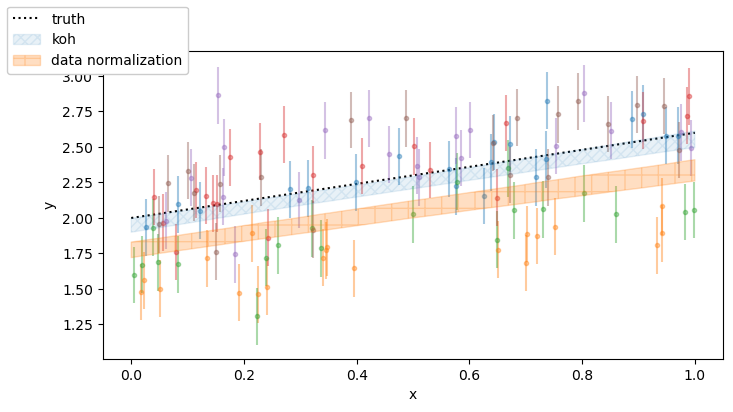

In [25]:
fig = plt.figure(figsize=(8, 4))
plt.plot(truth.x, truth.y, "k:", label="truth")

for synthetic_observation in observations:
    plt.errorbar(
        synthetic_observation.x,
        synthetic_observation.y,
        np.sqrt(np.diag(synthetic_observation.statistical_covariance)),
        linestyle="none",
        marker=".",
        alpha=0.4,
        # label=f"renormalization = {synthetic_observation.renormalization:1.3f}",
    )

hatches = ["//\\//\\", "|-", "", ""]
alphas = [0.1, 0.25, 0.25, 0.25]
for i, (key, walker) in enumerate(walkers.items()):
    intervals = predictive_post(
        walker.model_sampler.chain,
        model,
        truth,
        1000,
        [16, 84],
    )
    plt.fill_between(
        truth.x,
        intervals[0],
        intervals[1],
        alpha=alphas[i],
        color=colors[key],
        label=key,
        hatch=hatches[i],
        zorder=99,
    )
plt.xlabel("x")
plt.ylabel("y")

fig.legend(loc="upper left", framealpha=1)